# Varying Dimension of Latent Space

## Preparing

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.datasets import cifar10

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as kb
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
(X_train, _), (X_test, labels_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
labels_name = {0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}



## Loop

In [3]:
def CreateEncoder(dim):
    # model: encoder
    encoded = Conv2D(64, (3, 3), activation='relu', 
                                    padding='same')(input_img)
    #encoded = Conv2D(64, (3, 3), activation='relu', 
    #                                padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(32, (3, 3), activation='relu', 
                                    padding='same')(encoded)
    #encoded = Conv2D(32, (3, 3), activation='relu', 
    #                                padding='same')(encoded)                                
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)

    input_encoded_before_flatten = kb.int_shape(encoded)
    encoded = Flatten()(encoded)
    encoded = Dense(dim, activation='relu')(encoded)
    encoder = Model(input_img, encoded)

    return encoder

def CreateDecoder(dim):
    # model: decoder
    input_encoded = Input(shape=(dim,))
    decoded = Dense(512, activation='relu')(input_encoded)
    decoded = Reshape((8,8,8))(decoded)
    decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
    decoder = Model(input_encoded, decoded)

    return decoder



In [4]:
dims = [512, 256, 128, 64, 32, 1]
ephochs = [20, 15, 10, 10, 10, 10]
input_img = Input(shape=(32,32,3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0005)

lucky_sample = 47;
decoded_imgs = np.zeros((len(dims),32,32,3))
loss_test = np.zeros(len(dims))

for i in range(len(dims)):
    dim = dims[i]
    ephoch = ephochs[i]
    encoder = CreateEncoder(dim)
    decoder = CreateDecoder(dim)

    encoded = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder = Model(input_img, decoded)

    optimizer = Adam(learning_rate=0.003)
    bce = tf.keras.losses.BinaryCrossentropy()
    mse = tf.keras.losses.MeanSquaredError()

    autoencoder.compile(optimizer=optimizer, loss=bce)

    autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=128,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping], # stop the training when no improvements are made
                verbose=1)
    
    decoded_img = autoencoder.predict(X_test[lucky_sample].reshape(-1,32,32,3))
    decoded_imgs[i] = decoded_img
    loss_test[i] = bce(X_test.reshape(-1,32*32*3),decoded_imgs.reshape(-1,32*32*3)).numpy()
    i = i+1



Epoch 1/10
391/391 [==============================] - 9s 17ms/step - loss: 0.6231 - val_loss: 0.5824
Epoch 2/10
391/391 [==============================] - 6s 15ms/step - loss: 0.5798 - val_loss: 0.5757
Epoch 3/10
391/391 [==============================] - 6s 16ms/step - loss: 0.5744 - val_loss: 0.5734
Epoch 4/10
391/391 [==============================] - 6s 15ms/step - loss: 0.5724 - val_loss: 0.5715
Epoch 5/10
391/391 [==============================] - 6s 15ms/step - loss: 0.5702 - val_loss: 0.5712
Epoch 6/10
391/391 [==============================] - 6s 16ms/step - loss: 0.5698 - val_loss: 0.5696
Epoch 7/10
391/391 [==============================] - 6s 16ms/step - loss: 0.5691 - val_loss: 0.5700
Epoch 8/10
391/391 [==============================] - 6s 15ms/step - loss: 0.5679 - val_loss: 0.5692
Epoch 9/10
391/391 [==============================] - 6s 15ms/step - loss: 0.5676 - val_loss: 0.5690
Epoch 10/10
391/391 [==============================] - 6s 15ms/step - loss: 0.5673 - val_lo

InvalidArgumentError: required broadcastable shapes at loc(unknown) [Op:Mul]

## Plot

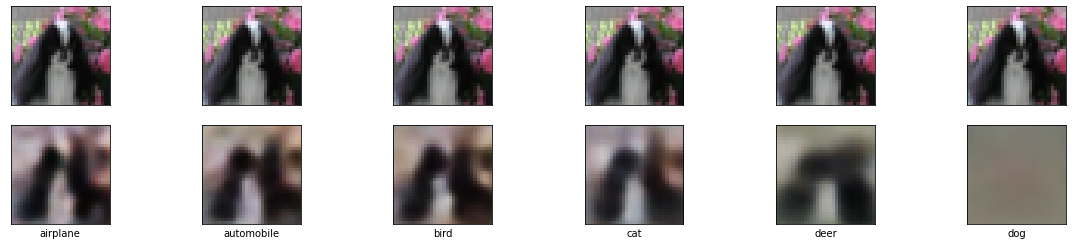

In [18]:
n = len(dims)  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[lucky_sample])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(labels_name[i])
#plt.savefig('images/cifar10_ae/cifar10_with_diff_latent_dim.png', dpi=120)
plt.show()